### PPE-Vision Segmentation Training
#### Project Context:
We have successfully trained a YOLOv8 object detection model to detect PPE items (Hardhat, Vest, Gloves, Boots, Mask, Person) using bounding boxes.
Now, we are moving to Segmentation to achieve pixel-level precision in PPE compliance detection.

#### Why Segmentation?
* Detection (Bounding Boxes) tells where objects are.

* Segmentation (Pixel Masks) tells which exact pixels belong to the object.

* In complex industrial environments, bounding boxes may overlap PPE items.

* Segmentation helps in fine-grained safety checks like:

    * Checking if the vest is properly worn.

    * Distinguishing gloves from nearby equipment.

    * Handling overlapping objects (e.g., Hardhat + Mask).

#### Current Dataset Status:
* You have a Segmentation Dataset with:
    * train/images/ and train/labels/

    * data.yaml file defining class names.

* There are no validation or test sets yet.

    * We will manually split a portion of train into validation (e.g., 20% of images).

In [1]:
!nvidia-smi

Tue Jul 29 12:09:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3

In [3]:
from google.colab import drive
import json

# Mount Google Drive
drive.mount('/content/drive')

# Load the API key from config.json
with open('/content/drive/MyDrive/PPE-Vision/config.json') as config_file:
    config = json.load(config_file)

Mounted at /content/drive


In [4]:

from roboflow import Roboflow
rf = Roboflow(api_key=config['ROBOFLOW_API_KEY'])
project = rf.workspace("testing-typbl").project("dataset-ppe-segmentation")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Dataset-PPE-(Segmentation)-3 in yolov8:: 100%|██████████| 9054/9054 [00:02<00:00, 4472.71it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
!mkdir -p /content/drive/MyDrive/PPE-Vision/datasets/segmentation/
!cp -r "/content/Dataset-PPE-(Segmentation)-3" /content/drive/MyDrive/PPE-Vision/datasets/segmentation

In [6]:
!ls /content/drive/MyDrive/PPE-Vision/datasets/segmentation/

'Dataset-PPE-(Segmentation)-3'


In [7]:
import os
import random
import shutil

# Paths
base_dir = '/content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3'
train_images_dir = os.path.join(base_dir, 'train/images')
train_labels_dir = os.path.join(base_dir, 'train/labels')

# Create validation folders
valid_images_dir = os.path.join(base_dir, 'valid/images')
valid_labels_dir = os.path.join(base_dir, 'valid/labels')

os.makedirs(valid_images_dir, exist_ok=True)
os.makedirs(valid_labels_dir, exist_ok=True)

# List all images
images = os.listdir(train_images_dir)

# Shuffle and select 20% for validation
random.shuffle(images)
val_count = int(0.2 * len(images))
val_images = images[:val_count]

# Move selected images and corresponding labels to validation folder
for img_file in val_images:
    # Move image
    shutil.move(os.path.join(train_images_dir, img_file), os.path.join(valid_images_dir, img_file))

    # Move corresponding label (same filename but .txt)
    label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
    shutil.move(os.path.join(train_labels_dir, label_file), os.path.join(valid_labels_dir, label_file))

print(f"Moved {val_count} images to validation set.")


Moved 904 images to validation set.


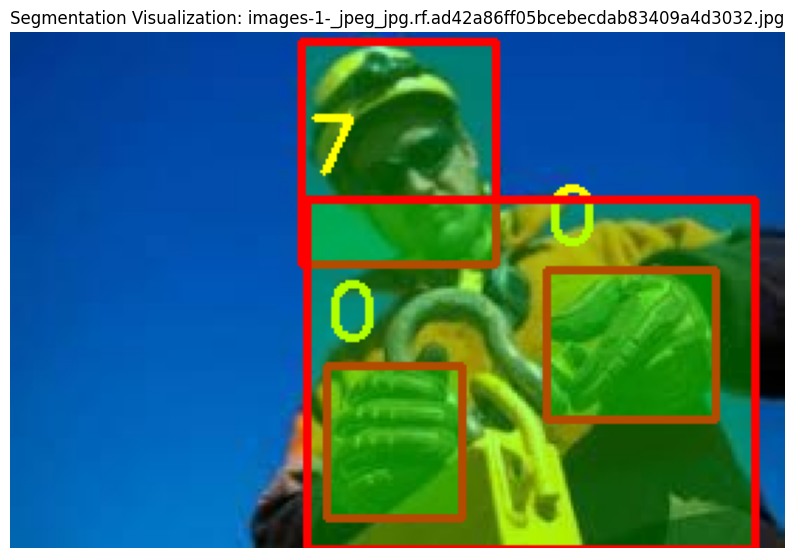

In [8]:
import cv2
import matplotlib.pyplot as plt
import random
import os
import numpy as np

# Set paths
images_dir = '/content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/train/images'
labels_dir = '/content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/train/labels'

# Pick a random image
random_image = random.choice(os.listdir(images_dir))
image_path = os.path.join(images_dir, random_image)

# Corresponding label file
label_path = os.path.join(labels_dir, random_image.replace('.jpg', '.txt').replace('.png', '.txt'))

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

# Read YOLOv8 segmentation label file
with open(label_path, 'r') as f:
    lines = f.readlines()

# Draw segmentation masks
for line in lines:
    coords = list(map(float, line.strip().split()))
    class_id = int(coords[0])
    poly_points = coords[1:]  # The rest are x1, y1, x2, y2, ..., xn, yn (normalized)

    # Convert normalized points to absolute pixel coordinates
    pts = []
    for i in range(0, len(poly_points), 2):
        x = int(poly_points[i] * w)
        y = int(poly_points[i + 1] * h)
        pts.append([x, y])

    # Convert to numpy array for cv2
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1, 1, 2))

    # Draw filled polygon mask (transparency)
    overlay = image.copy()
    cv2.fillPoly(overlay, [pts], color=(0, 255, 0))
    image = cv2.addWeighted(overlay, 0.3, image, 0.7, 0)

    # Draw polygon outline
    cv2.polylines(image, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

    # Draw class ID near first point
    cv2.putText(image, str(class_id), (pts[0][0][0], pts[0][0][1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)

# Show image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title(f"Segmentation Visualization: {random_image}")
plt.show()


In [9]:
# Read and display all unique class IDs in the current label file
with open(label_path, 'r') as f:
    lines = f.readlines()

# Extract class IDs
class_ids = set()
for line in lines:
    coords = list(map(float, line.strip().split()))
    class_ids.add(int(coords[0]))

print(f"Class IDs present in {random_image}: {class_ids}")

Class IDs present in images-1-_jpeg_jpg.rf.ad42a86ff05bcebecdab83409a4d3032.jpg: {0, 1, 7}


In [10]:
import yaml

# Path to your data.yaml file
data_yaml_path = '/content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/data.yaml'

# Load YAML content
with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

# Extract class names
class_names = data_yaml['names']

# Print all class labels with IDs
for idx, name in enumerate(class_names):
    print(f"Class ID {idx}: {name}")

Class ID 0: Gloves
Class ID 1: Helmet
Class ID 2: No-Gloves
Class ID 3: No-Helmet
Class ID 4: No-Shoes
Class ID 5: No-Vest
Class ID 6: Shoes
Class ID 7: Vest


In [11]:
from ultralytics import YOLO

# Load a YOLOv8 pre-trained segmentation model (start with nano or small)
model = YOLO('yolov8n-seg.pt')  # Use 'yolov8s-seg.pt' if you have better GPU resources.

# Train on your segmentation dataset
model.train(
    data='/content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/data.yaml',
    epochs=50,       # You can start with 50 epochs (adjust as needed)
    imgsz=640,       # Image size
    batch=16,        # Lower batch size if you run into memory issues (try 8)
    project='PPE_Vision_Segmentation',
    name='segmentation_model',
    workers=2        # Reduce workers for Colab to avoid crashing
)


100%|██████████| 6.74M/6.74M [00:00<00:00, 378MB/s]


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=segmentation_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, 

100%|██████████| 755k/755k [00:00<00:00, 99.9MB/s]

Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n-seg summary: 151 layers, 3,265,176 parameters, 3,265,160 gradients, 12.1 GFLOPs

Transferred 381/417 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 275MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.7±0.3 ms, read: 24.5±13.5 MB/s, size: 44.5 KB)


train: Scanning /content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/train/labels... 3620 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3620/3620 [00:58<00:00, 61.82it/s] 


train: New cache created: /content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 4.6±7.2 ms, read: 19.2±18.5 MB/s, size: 58.2 KB)


val: Scanning /content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/valid/labels... 904 images, 0 backgrounds, 0 corrupt: 100%|██████████| 904/904 [00:11<00:00, 80.53it/s] 


val: New cache created: /content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/valid/labels.cache
Plotting labels to PPE_Vision_Segmentation/segmentation_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to PPE_Vision_Segmentation/segmentation_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.33G      1.481      2.494      2.726      1.421         27        640: 100%|██████████| 227/227 [01:57<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]


                   all        904       4084      0.492      0.557      0.516      0.285      0.481       0.54      0.496      0.248

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.56G      1.453       1.64      1.901      1.374         55        640: 100%|██████████| 227/227 [01:50<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]


                   all        904       4084      0.592      0.538      0.546      0.302      0.575      0.522      0.523      0.267

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.57G       1.46      1.621      1.809      1.389         24        640: 100%|██████████| 227/227 [01:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.81it/s]


                   all        904       4084      0.556      0.534      0.555      0.302       0.54      0.523      0.528       0.26

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50       4.6G      1.462      1.652      1.701      1.379         24        640: 100%|██████████| 227/227 [01:53<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.75it/s]


                   all        904       4084      0.651      0.572      0.627      0.352      0.638       0.56      0.606      0.311

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.62G      1.433      1.576      1.585      1.362         41        640: 100%|██████████| 227/227 [01:50<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.75it/s]


                   all        904       4084      0.716      0.637      0.691      0.393      0.704      0.626      0.671      0.346

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.63G      1.414      1.578      1.515      1.338         54        640: 100%|██████████| 227/227 [01:47<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.75it/s]


                   all        904       4084      0.699      0.631      0.689      0.396      0.688      0.616      0.665      0.339

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.64G       1.39      1.537      1.448      1.332         50        640: 100%|██████████| 227/227 [01:47<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.78it/s]


                   all        904       4084      0.722      0.655      0.707      0.413      0.707      0.637      0.682      0.353

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.67G      1.377      1.537      1.423      1.333         17        640: 100%|██████████| 227/227 [01:48<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]


                   all        904       4084      0.721      0.676      0.738      0.441      0.709      0.668      0.719      0.387

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.69G      1.348      1.497      1.346      1.304         51        640: 100%|██████████| 227/227 [01:48<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.70it/s]


                   all        904       4084      0.723      0.666      0.722      0.427      0.703      0.655      0.693      0.366

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.71G      1.357      1.488      1.321      1.312         29        640: 100%|██████████| 227/227 [01:45<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


                   all        904       4084      0.769      0.685       0.75      0.454      0.757       0.67      0.729      0.396

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.71G      1.339      1.478      1.278      1.294         25        640: 100%|██████████| 227/227 [01:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:19<00:00,  1.52it/s]


                   all        904       4084      0.747      0.685      0.745      0.444      0.746      0.663      0.724      0.389

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.74G      1.331      1.469      1.259      1.288         42        640: 100%|██████████| 227/227 [01:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]


                   all        904       4084       0.76      0.718      0.772      0.463      0.748      0.703       0.75      0.407

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.76G      1.316      1.422      1.222      1.278         41        640: 100%|██████████| 227/227 [01:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


                   all        904       4084      0.789      0.679      0.763      0.455      0.782      0.662      0.736      0.392

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.78G      1.304      1.454      1.205      1.273         16        640: 100%|██████████| 227/227 [01:46<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.01it/s]


                   all        904       4084      0.783      0.722       0.79      0.481      0.773      0.705      0.769      0.427

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.79G      1.305      1.415      1.191      1.273         21        640: 100%|██████████| 227/227 [01:46<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.99it/s]


                   all        904       4084      0.809      0.735      0.804      0.498      0.798      0.722      0.785      0.437

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.82G        1.3      1.439      1.168      1.263         29        640: 100%|██████████| 227/227 [01:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.97it/s]


                   all        904       4084      0.803      0.746      0.808      0.501      0.795      0.724      0.783      0.441

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.84G      1.277      1.379      1.134      1.253         33        640: 100%|██████████| 227/227 [01:45<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.00it/s]


                   all        904       4084      0.801      0.741      0.811      0.509      0.789      0.728      0.792      0.444

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.85G      1.275      1.403      1.114      1.249         56        640: 100%|██████████| 227/227 [01:46<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]


                   all        904       4084      0.813      0.723      0.807      0.501      0.801      0.708      0.784      0.439

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.86G      1.264      1.382      1.101      1.251         37        640: 100%|██████████| 227/227 [01:46<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all        904       4084      0.802      0.747      0.814      0.506      0.791       0.73      0.793      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.89G      1.253      1.377      1.072      1.242         19        640: 100%|██████████| 227/227 [01:45<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:20<00:00,  1.39it/s]

                   all        904       4084      0.825      0.748      0.819      0.512      0.813      0.733      0.797      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.91G      1.262      1.364      1.066      1.236         26        640: 100%|██████████| 227/227 [01:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:23<00:00,  1.22it/s]


                   all        904       4084      0.824      0.749      0.826      0.508      0.811      0.736      0.805      0.443

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.93G       1.24      1.353      1.048      1.228         26        640: 100%|██████████| 227/227 [01:50<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


                   all        904       4084       0.83      0.753      0.832      0.526      0.818       0.74      0.814      0.459

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.94G      1.246      1.356       1.05      1.231         39        640: 100%|██████████| 227/227 [01:48<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


                   all        904       4084      0.819      0.762      0.829      0.526      0.809      0.747      0.806      0.464

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.97G      1.226      1.329      1.019      1.218         29        640: 100%|██████████| 227/227 [01:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:19<00:00,  1.50it/s]


                   all        904       4084      0.819      0.764      0.832      0.527      0.807       0.75      0.812       0.46

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.98G      1.231      1.331      1.005      1.218         35        640: 100%|██████████| 227/227 [01:47<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]


                   all        904       4084      0.831       0.76      0.829      0.524      0.821      0.747      0.812      0.452

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.01G      1.223      1.341      1.007      1.217         28        640: 100%|██████████| 227/227 [01:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.98it/s]


                   all        904       4084      0.823      0.762      0.829      0.523      0.816      0.746      0.808      0.455

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.02G      1.203      1.288     0.9845      1.206         12        640: 100%|██████████| 227/227 [01:48<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.84it/s]


                   all        904       4084      0.832       0.76      0.835      0.534      0.824      0.741      0.815      0.468

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.04G      1.197      1.297     0.9667        1.2         17        640: 100%|██████████| 227/227 [01:48<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.84it/s]


                   all        904       4084       0.84      0.761      0.842      0.533      0.831      0.746      0.822      0.469

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.06G      1.193      1.302     0.9559      1.196         43        640: 100%|██████████| 227/227 [01:48<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.87it/s]


                   all        904       4084      0.831      0.771       0.84      0.541      0.824      0.756      0.822      0.474

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.08G      1.193      1.303     0.9393      1.192         33        640: 100%|██████████| 227/227 [01:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.01it/s]


                   all        904       4084      0.837      0.777      0.846      0.543      0.825      0.767      0.827      0.481

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.09G      1.195        1.3     0.9486      1.195         22        640: 100%|██████████| 227/227 [01:45<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.93it/s]


                   all        904       4084      0.847       0.79      0.849      0.543      0.836      0.776       0.83      0.478

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.12G      1.181      1.278     0.9356      1.192         23        640: 100%|██████████| 227/227 [01:46<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.02it/s]


                   all        904       4084      0.833      0.784      0.848      0.541      0.826      0.765      0.825      0.474

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.13G      1.169      1.275     0.9107      1.185         45        640: 100%|██████████| 227/227 [01:45<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


                   all        904       4084      0.848      0.779      0.851      0.546      0.841      0.766      0.832      0.481

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.15G      1.174      1.259      0.901      1.184         16        640: 100%|██████████| 227/227 [01:47<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


                   all        904       4084      0.828      0.801      0.853      0.547      0.818      0.786      0.833      0.482

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.16G      1.159      1.261     0.8934      1.176         22        640: 100%|██████████| 227/227 [01:49<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.97it/s]


                   all        904       4084      0.829      0.802      0.856      0.553      0.816      0.789      0.837      0.489

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.19G      1.158      1.269     0.8923      1.177         20        640: 100%|██████████| 227/227 [01:49<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.04it/s]


                   all        904       4084      0.842      0.791      0.855      0.551      0.831      0.775      0.834      0.483

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.21G      1.155      1.231     0.8801      1.176         18        640: 100%|██████████| 227/227 [01:45<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.92it/s]


                   all        904       4084      0.842      0.798      0.857      0.552      0.833      0.782       0.84      0.497

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.23G      1.152      1.251     0.8654      1.171         22        640: 100%|██████████| 227/227 [01:45<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


                   all        904       4084      0.852      0.799      0.859      0.558      0.839      0.783      0.839      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.23G      1.136      1.229     0.8562      1.161         20        640: 100%|██████████| 227/227 [01:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


                   all        904       4084      0.849      0.799      0.862      0.561       0.84      0.781      0.843      0.498

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.26G      1.139      1.227     0.8558      1.162         31        640: 100%|██████████| 227/227 [01:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]


                   all        904       4084       0.85      0.807      0.862      0.559       0.85      0.781      0.841      0.492
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.28G      1.081       1.11     0.7078      1.131         12        640: 100%|██████████| 227/227 [01:33<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.10it/s]


                   all        904       4084      0.845        0.8      0.859      0.558      0.843      0.781      0.841      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50       5.3G      1.053      1.094     0.6757      1.118         16        640: 100%|██████████| 227/227 [01:30<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.10it/s]


                   all        904       4084      0.869      0.797      0.865      0.562      0.856      0.786      0.845      0.499

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.31G      1.048      1.086     0.6627      1.109         36        640: 100%|██████████| 227/227 [01:29<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]

                   all        904       4084       0.87      0.802      0.865      0.565      0.859      0.792       0.85      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.34G      1.046      1.075       0.66      1.113         19        640: 100%|██████████| 227/227 [01:30<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.10it/s]


                   all        904       4084      0.858      0.801      0.866      0.565      0.847      0.786      0.845      0.499

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.36G      1.035      1.069     0.6401      1.101         21        640: 100%|██████████| 227/227 [01:29<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


                   all        904       4084      0.849      0.815      0.868      0.568      0.837      0.805      0.851      0.504

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.38G      1.032      1.055     0.6417      1.099         33        640: 100%|██████████| 227/227 [01:29<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.07it/s]

                   all        904       4084      0.866      0.811      0.872      0.572      0.858      0.796      0.855      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.38G      1.018      1.035     0.6228      1.092         10        640: 100%|██████████| 227/227 [01:30<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.14it/s]

                   all        904       4084      0.867      0.811      0.872      0.572      0.857      0.801      0.856      0.509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.42G      1.012      1.029     0.6232      1.093         12        640: 100%|██████████| 227/227 [01:29<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.10it/s]


                   all        904       4084      0.866      0.814       0.87      0.572      0.855      0.802      0.854      0.511

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.43G      1.003      1.021     0.6068      1.084         10        640: 100%|██████████| 227/227 [01:29<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.13it/s]


                   all        904       4084       0.86      0.822      0.872      0.575      0.848      0.806      0.852      0.513

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.45G      1.001      1.019     0.6115      1.084         11        640: 100%|██████████| 227/227 [01:28<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]


                   all        904       4084      0.861      0.823      0.874      0.576      0.852       0.81      0.858      0.512

50 epochs completed in 1.679 hours.
Optimizer stripped from PPE_Vision_Segmentation/segmentation_model/weights/last.pt, 6.8MB
Optimizer stripped from PPE_Vision_Segmentation/segmentation_model/weights/best.pt, 6.8MB

Validating PPE_Vision_Segmentation/segmentation_model/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,259,624 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/29 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   3%|▎         | 1/29 [00:00<00:09,  3.10it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 2/29 [00:01<00:17,  1.51it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.84it/s]


                   all        904       4084      0.862      0.822      0.874      0.576      0.853       0.81      0.857      0.512
                Gloves        254        498      0.809      0.724      0.785      0.543      0.801      0.711      0.772       0.49
                Helmet        232        485      0.944      0.909      0.958      0.701      0.942      0.907      0.957      0.638
             No-Gloves        233        606      0.778      0.673      0.739      0.414      0.764       0.66      0.717      0.356
             No-Helmet        217        417      0.881      0.904      0.932       0.65      0.869      0.891       0.91      0.585
              No-Shoes        249        558      0.876      0.835      0.898      0.567      0.864      0.823      0.877      0.512
               No-Vest        243        456      0.857      0.854      0.891      0.563      0.843      0.838      0.874      0.486
                 Shoes        234        647      0.841      0.762   

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a48435eae10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0

In [17]:
# Copy the trained segmentation model to your Drive
!cp /content/PPE_Vision_Segmentation/segmentation_model/weights/best.pt /content/drive/MyDrive/PPE-Vision/models/ppe_segmentation_best.pt


In [18]:
from ultralytics import YOLO

# Load the saved segmentation model from Drive
model = YOLO('/content/drive/MyDrive/PPE-Vision/models/ppe_segmentation_best.pt')

# Run validation to fetch metrics
metrics = model.val()

# Print Box & Mask Metrics
print(f"Box Precision: {metrics.box.mp:.3f}")
print(f"Box Recall: {metrics.box.mr:.3f}")
print(f"Box mAP50: {metrics.box.map50:.3f}")
print(f"Box mAP50-95: {metrics.box.map:.3f}")

print(f"Mask Precision: {metrics.seg.mp:.3f}")
print(f"Mask Recall: {metrics.seg.mr:.3f}")
print(f"Mask mAP50: {metrics.seg.map50:.3f}")
print(f"Mask mAP50-95: {metrics.seg.map:.3f}")


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,259,624 parameters, 0 gradients, 12.0 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.4 ms, read: 68.0±112.5 MB/s, size: 239.2 KB)


val: Scanning /content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/valid/labels.cache... 904 images, 0 backgrounds, 0 corrupt: 100%|██████████| 904/904 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/57 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▎         | 2/57 [00:04<01:46,  1.93s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:19<00:00,  2.89it/s]


                   all        904       4084      0.863      0.822      0.875      0.576      0.851      0.808      0.856      0.508
                Gloves        254        498      0.812       0.72      0.786      0.546      0.802      0.706      0.773       0.49
                Helmet        232        485      0.946      0.909      0.959      0.701      0.942      0.905      0.952      0.631
             No-Gloves        233        606      0.781      0.675      0.742      0.416      0.762      0.657      0.711      0.352
             No-Helmet        217        417      0.877      0.906      0.933      0.653      0.861      0.888      0.911      0.579
              No-Shoes        249        558      0.875      0.837      0.896      0.565      0.863      0.824      0.876      0.507
               No-Vest        243        456      0.854      0.853      0.892      0.564      0.844       0.84      0.874      0.484
                 Shoes        234        647      0.849      0.762   

In [19]:
# Run inference on validation images
results = model.predict(
    source='/content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/valid/images',
    save=True,
    conf=0.5,
    project='runs/segment',
    name='ppe_segmentation_inference',
    line_width=2
)


image 1/904 /content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/valid/images/00021a200ea0bd61_jpg.rf.cba8b95f3fd9ddefcc5b9da4e1b37986.jpg: 448x640 1 Shoes, 75.6ms
image 2/904 /content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/valid/images/00252_jpg.rf.1c29e1e102c68ba1ef6ab8d3040541f0.jpg: 416x640 1 Gloves, 2 Helmets, 2 Vests, 46.5ms
image 3/904 /content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/valid/images/00306_jpg.rf.0b6c491e7a94d48fdf494e9b34ab83c0.jpg: 640x640 1 Helmet, 2 No-Glovess, 1 Vest, 10.3ms
image 4/904 /content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/valid/images/00341_jpg.rf.bf0da8af58adee87c042c133abf904f2.jpg: 448x640 2 Helmets, 2 No-Glovess, 2 Vests, 9.1ms
image 5/904 /content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/valid/images/00411_jpg.rf.8c8a52e5609d924266a20b9a90daffa5.jpg: 384x640 3 Helmets, 

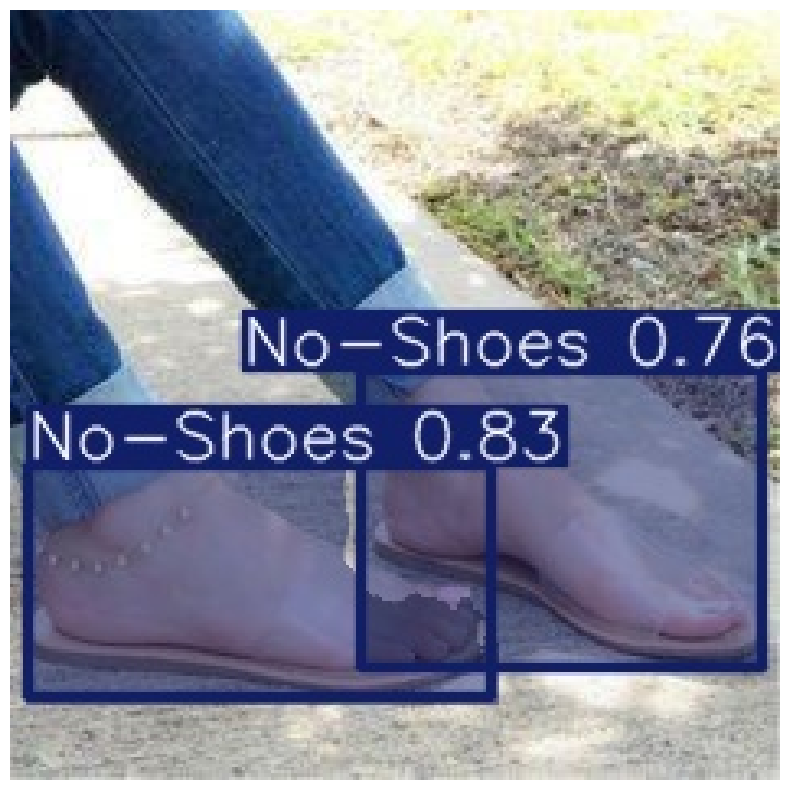

In [20]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Load the first saved image
pred_dir = '/content/runs/segment/ppe_segmentation_inference'
pred_images = os.listdir(pred_dir)

# Display one image
img_path = os.path.join(pred_dir, pred_images[0])
img = Image.open(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

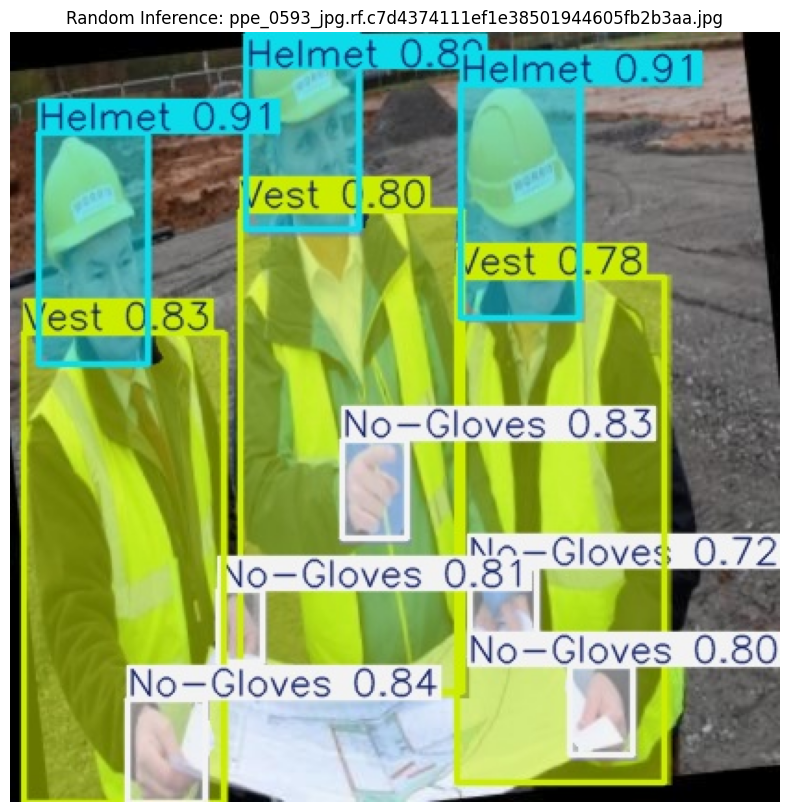

In [21]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Path to your inference results folder
pred_dir =  '/content/runs/segment/ppe_segmentation_inference'  # Update if folder name is different

# List all prediction images
pred_images = os.listdir(pred_dir)

# Ensure there are images
if pred_images:
    # Pick a random image
    random_image = random.choice(pred_images)
    img_path = os.path.join(pred_dir, random_image)

    # Open and display the image
    img = Image.open(img_path)
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Random Inference: {random_image}")
    plt.show()
else:
    print("No prediction images found.")


In [24]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Path to your inference results folder
pred_dir = '/content/runs/segment/ppe_segmentation_inference'  # Change folder name if different

# List all predicted images
pred_images = os.listdir(pred_dir)

# Ensure there are images
if pred_images:
    # Randomly select 5 unique images
    random_images = random.sample(pred_images, min(5, len(pred_images)))

    # Plot them
    plt.figure(figsize=(40, 20))  # Adjust the size as needed

    for i, img_file in enumerate(random_images):
        img_path = os.path.join(pred_dir, img_file)
        img = Image.open(img_path)

        plt.subplot(1, 5, i+1)  # 1 row, 5 columns
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{img_file[:15]}...")  # Short title

    plt.tight_layout()
    plt.show()

else:
    print("No prediction images found.")


Output hidden; open in https://colab.research.google.com to view.